# Embedding Model

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [4]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Deep Embedding Clustering (DEC) Model

In [5]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_shape[1]),
                                        initializer='glorot_uniform')

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / 1.0))
        q = q ** ((1.0 + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

class DEC:
    def __init__(self, input_dim, encoding_dim, n_clusters, dropout_rate=0.2):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.n_clusters = n_clusters
        self.dropout_rate = dropout_rate
        self.autoencoder, self.encoder = self.build_autoencoder()
        self.model = self.build_dec_model()

    def build_autoencoder(self):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dropout(self.dropout_rate)(encoder)
        encoder = Dense(self.encoding_dim, activation='relu', kernel_initializer='glorot_uniform')(encoder)

        decoder = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(encoder)
        decoder = Dropout(self.dropout_rate)(decoder)
        decoder = Dense(self.input_dim, activation='sigmoid', kernel_initializer='glorot_uniform')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer='adam', loss='mse')

        encoder_model = Model(inputs=input_layer, outputs=encoder)
        return autoencoder, encoder_model

    def build_dec_model(self):
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        model = Model(inputs=self.encoder.input, outputs=[clustering_layer, self.autoencoder.output])
        model.compile(optimizer='adam', loss=['kld', 'mse'])
        return model

    def pretrain_autoencoder(self, data, epochs=50, batch_size=256):
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping])

    def initialize_clusters(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            encoded_data = self.encoder.predict(data)
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            kmeans.fit(encoded_data)
            initial_clusters = kmeans.cluster_centers_
            self.model.get_layer(name='clustering').set_weights([initial_clusters])

    def target_distribution(self, q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def train_dec(self, data, maxiter=8000, update_interval=140, tol=0.001):
        index = 0
        y_pred_last = None
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            for ite in range(maxiter):
                if ite % update_interval == 0:
                    q, _ = self.model.predict(data, verbose=0)
                    p = self.target_distribution(q)

                    y_pred = q.argmax(1)
                    if ite > 0 and np.sum(y_pred != y_pred_last) / len(y_pred) < tol:
                        print('Reached tolerance threshold. Stopping training.')
                        break
                    y_pred_last = np.copy(y_pred)

                idx = index * update_interval % data.shape[0]
                loss = self.model.train_on_batch(x=data[idx:idx + update_interval],
                                                 y=[p[idx:idx + update_interval], data[idx:idx + update_interval]])
                index += 1
                print('Iteration', ite, 'Loss:', loss)

    def predict(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            q, _ = self.model.predict(data)
            return q.argmax(1)
    
    def summary(self):
        print("Auto Encoder Summary:")
        self.autoencoder.summary()
        print("DEC Model Summary:")
        self.model.summary()

In [6]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [7]:
scores_df

,license_value_score,customer_value_score
0,0.225903,0.404288
1,0.692198,0.000000
2,0.025903,0.058008
3,0.825945,0.703012
4,0.826668,0.467596
...,...,...
99995,0.475269,0.683419
99996,0.562420,0.861997
99997,0.225903,0.243447
99998,0.073531,0.058008


In [8]:
score_features.shape

(100000, 2)

In [9]:
# Parameters
input_dim = score_features.shape[1]
encoding_dim = 2
n_clusters = 10
dropout_rate = 0.2

In [10]:
# Create DEC instance
dec = DEC(input_dim, encoding_dim, n_clusters, dropout_rate)

In [11]:
dec.summary()

Auto Encoder Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 64)                192       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2) 

In [12]:
# Pretrain autoencoder
dec.pretrain_autoencoder(score_features, epochs=50, batch_size=256)

Epoch 1/50
391/391 [==============================] - 3s 2ms/step - loss: 0.0239
Epoch 2/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 3/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0034
Epoch 4/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 5/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 6/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0020
Epoch 7/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 8/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 9/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 10/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 11/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 12/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 13/50
391/391 [====

In [13]:
# Initialize clusters
dec.initialize_clusters(score_features)

3125/3125 [==============================] - 2s 546us/step


In [14]:
# Train DEC model
dec.train_dec(score_features, maxiter=8000, update_interval=140, tol=0.001)

Iteration 0 Loss: [0.0823163390159607, 0.08119793236255646, 0.0011184089817106724]
Iteration 1 Loss: [0.0743807926774025, 0.07316673547029495, 0.001214057905599475]
Iteration 2 Loss: [0.07191263139247894, 0.07081601768732071, 0.0010966132394969463]
Iteration 3 Loss: [0.0676259994506836, 0.06645292788743973, 0.0011730737751349807]
Iteration 4 Loss: [0.06694690883159637, 0.0655902698636055, 0.0013566362904384732]
Iteration 5 Loss: [0.08242597430944443, 0.08115901798009872, 0.001266954466700554]
Iteration 6 Loss: [0.061097003519535065, 0.05981725826859474, 0.0012797453673556447]
Iteration 7 Loss: [0.06393171101808548, 0.06253610551357269, 0.0013956081820651889]
Iteration 8 Loss: [0.06681636720895767, 0.06546444445848465, 0.001351921702735126]
Iteration 9 Loss: [0.07980839163064957, 0.07824769616127014, 0.001560696167871356]
Iteration 10 Loss: [0.07207903265953064, 0.07050115615129471, 0.0015778779052197933]
Iteration 11 Loss: [0.07722988724708557, 0.07557257264852524, 0.001657312852330505

In [15]:
# Predict clusters
clusters = dec.predict(score_features)
print("Predicted clusters:", clusters)

   1/3125 [..............................] - ETA: 37s

3125/3125 [==============================] - 3s 858us/step
Predicted clusters: [0 7 0 ... 0 0 3]


In [16]:
embeddings = dec.encoder.predict(score_features)

3125/3125 [==============================] - 2s 657us/step


## Determine the number of clusters(k)

In [17]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


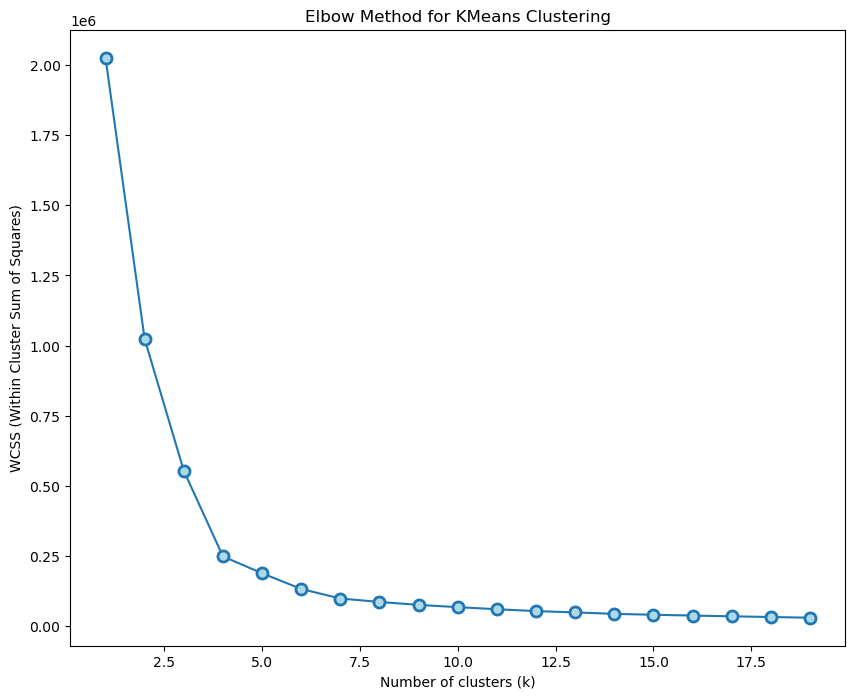

In [18]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [19]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=4, random_state=0).fit(embeddings)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df['cluster_kmeans'] = kmeans.predict(embeddings)
df_latex = df.groupby(['cluster_kmeans']).mean()
df_latex

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
cluster_kmeans,,,,,,,,,,,
0,0.548626,0.711452,0.365323,0.084845,0.141898,0.164561,0.093028,0.420227,0.095441,0.560413,0.224181
1,0.615637,0.804180,0.237814,0.078072,0.150525,0.137759,0.077086,0.438316,0.118241,0.807415,0.741564
2,0.422919,0.734061,0.727072,0.073923,0.123177,0.167017,0.116961,0.430083,0.088840,0.183790,0.206535
3,0.450251,0.818444,0.478225,0.062206,0.134769,0.130532,0.088806,0.477990,0.105697,0.419475,0.703342


In [20]:
df_latex = df_latex.T

In [21]:
df_latex

cluster_kmeans,0,1,2,3
yeojohnson_revenue_in_eur_bin,0.548626,0.615637,0.422919,0.450251
is_EMEA,0.711452,0.804180,0.734061,0.818444
is_Webshop,0.365323,0.237814,0.727072,0.478225
is_industry_FinanceInsuranceRealEstate,0.084845,0.078072,0.073923,0.062206
is_industry_Manufacturing,0.141898,0.150525,0.123177,0.134769
is_industry_Other,0.164561,0.137759,0.167017,0.130532
is_industry_RetailTrade,0.093028,0.077086,0.116961,0.088806
is_industry_Services,0.420227,0.438316,0.430083,0.477990
is_industry_WholesaleTrade,0.095441,0.118241,0.088840,0.105697
license_value_score,0.560413,0.807415,0.183790,0.419475


In [22]:
latex_table = df_latex.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Average Values of each feature per Cluster",  # The caption to appear above the table in the LaTeX document
    label="tab:avg_clusters",  # A label used for referencing the table within the LaTeX document
    position="H",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="cccc",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.3f}".format  # Formats floats to two decimal places
)

print(latex_table)

\begin{table}[H]
\centering
\caption{Average Values of each feature per Cluster}
\label{tab:avg_clusters}
\begin{tabular}{cccc}
\toprule
    0 &     1 &     2 &     3 \\
\midrule
0.549 & 0.616 & 0.423 & 0.450 \\
0.711 & 0.804 & 0.734 & 0.818 \\
0.365 & 0.238 & 0.727 & 0.478 \\
0.085 & 0.078 & 0.074 & 0.062 \\
0.142 & 0.151 & 0.123 & 0.135 \\
0.165 & 0.138 & 0.167 & 0.131 \\
0.093 & 0.077 & 0.117 & 0.089 \\
0.420 & 0.438 & 0.430 & 0.478 \\
0.095 & 0.118 & 0.089 & 0.106 \\
0.560 & 0.807 & 0.184 & 0.419 \\
0.224 & 0.742 & 0.207 & 0.703 \\
\bottomrule
\end{tabular}
\end{table}



In [23]:
df.cluster_kmeans.value_counts()

2    36200
0    26519
1    20289
3    16992
Name: cluster_kmeans, dtype: int64

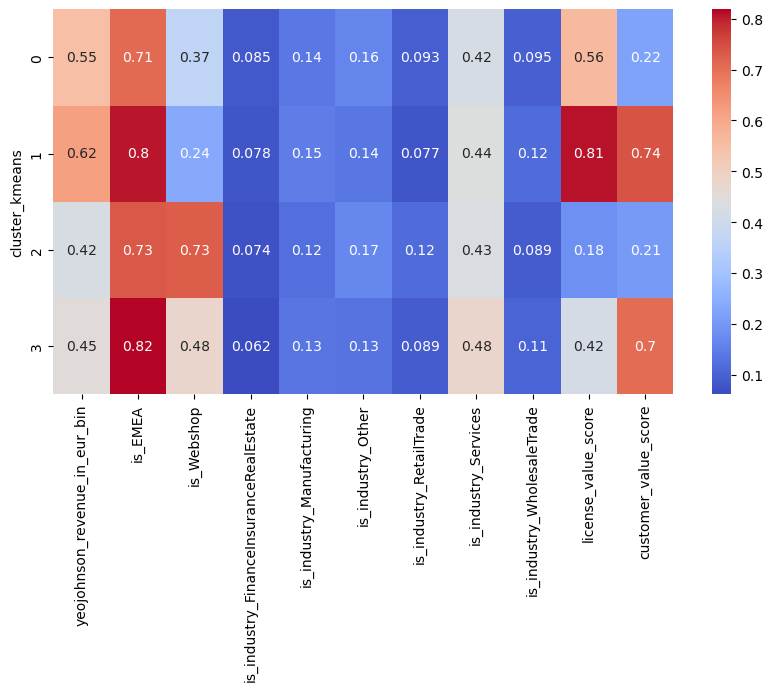

In [24]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [25]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_

In [26]:
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", 
                    line_close=True,
                    height=800,
                    width=1400, 
                    title="DEC Model 2-Feature Set Radar Chart")
fig.show()

In [27]:
clusters_df = clusters.groupby('label').size().reset_index()
clusters_df.rename(columns={'label': 'cluster', 0: 'count'}, inplace=True)
clusters_df

,cluster,count
0,0,26519
1,1,20289
2,2,36200
3,3,16992


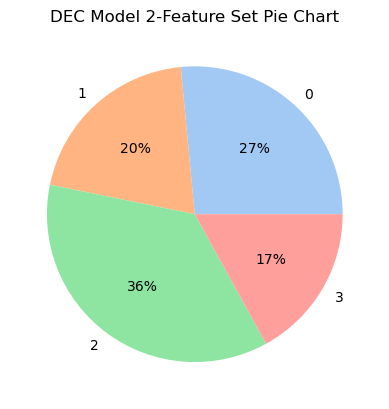

In [28]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(clusters_df['count'], labels = clusters_df['cluster'], colors = colors, autopct='%.0f%%')
plt.title('DEC Model 2-Feature Set Pie Chart')
plt.show()

## Evaluation

In [29]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.671


In [30]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(embeddings, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 0.504


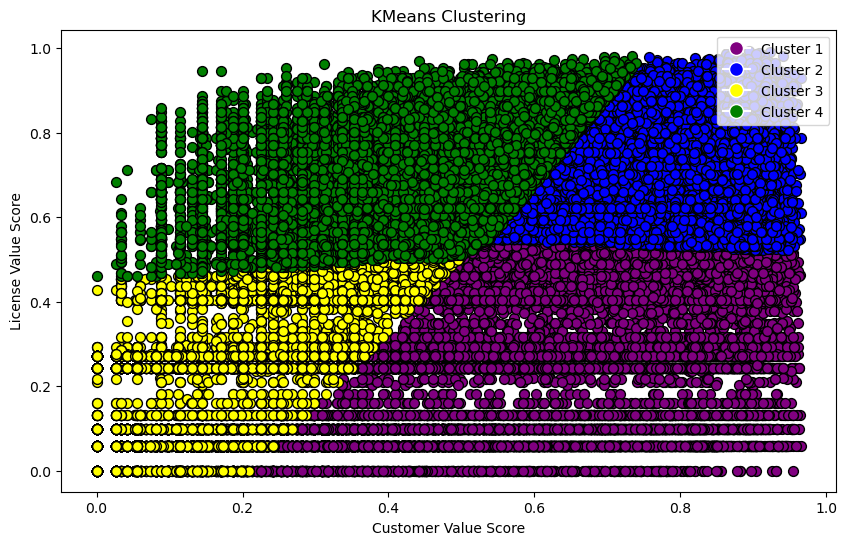

In [31]:
# Define colors for each cluster
cluster_colors = ['purple', 'blue', 'yellow', 'green']

# Plot the clusters using the first two features
plt.figure(figsize=(10, 6))

# Scatter plot of the data points, colored by cluster label
for i in range(kmeans.n_clusters):
    plt.scatter(score_features[:, -2][cluster_labels == i], score_features[:, -1][cluster_labels == i], color=cluster_colors[i], 
                label=f'Cluster {i+1}', marker='o', edgecolor='k', s=50)

# Create custom legend for clusters
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                          markerfacecolor=cluster_colors[i], markersize=10) for i in range(kmeans.n_clusters)]

# Add titles, labels and legend
plt.legend(handles=legend_elements, loc='upper right')
plt.title('KMeans Clustering')
plt.xlabel('Customer Value Score')
plt.ylabel('License Value Score')

# Show plot
plt.show()